In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
from importlib import reload

# get from /notebooks/ to /src/
src_path = Path("..", "src")
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [6]:
num_classes = 3
# the following is specific to a 3 class model. it will be different for 5
down_margin = 0.0038
up_margin = 0.0065

lag_factor = 5
test_size = 0.20

data = "BTCUSDT_30m_2020.csv"

from session_info import SessionInfo

session = SessionInfo(
    data, num_classes, lag_factor, test_size,
    up_margin=up_margin, down_margin=down_margin
)

df = pd.read_csv("./../input/" + data)
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

# drop rows where volume == 0
df = df.loc[df['volume'] != 0]

print(df.columns)
print(df.shape)

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume',
       'base_asset_volume', 'no_trades', 'taker_buy_vol',
       'taker_buy_base_asset_vol'],
      dtype='object')
(89869, 10)


In [7]:
import add_features as af
import feature_engineering as fe
reload(af)
reload(fe)

df = af.add_features(df, session)

#df = df.dropna()
# #for lag in range(1, lag_factor+1):
#     for col in cols:
#         newcol = np.zeros(df.shape[0]) * np.nan
#         newcol[lag:] = df[col].values[:-lag]
#         df.insert(len(df.columns), "{0}_{1}".format(col, lag), newcol)

# df = df.dropna()

# move the jump and target variable (jump_tmr) to the end
df = df[[col for col in df.columns if col not in ['next_jump']] + ['next_jump']]

# log what features we are using
features = [col for col in df.columns if col not in ['timestamp', 'next_jump']]
session.add_features(features)

print(df.shape)

unique, counts = np.unique(df['next_jump'], return_counts=True)
for u,c in zip(unique, counts):
    print(f'Jump: {u}, Count: {c}')

s_max = 2684.842810127005, s_min = 0.6427807644221296
s_max = 3290.051786594691, s_min = 5.284572232869327
s_max = 3881.9753149568924, s_min = 14.933965888037248
(89743, 196)
Jump: down, Count: 7838
Jump: neutral, Count: 78619
Jump: up, Count: 3286


In [8]:
from utility_functions import get_jump_lookup

jump_lookup = get_jump_lookup(num_classes=num_classes)


X = df.drop(['timestamp', 'next_jump'], axis=1).copy()
y = df['next_jump'].copy()
y = y.map(jump_lookup)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

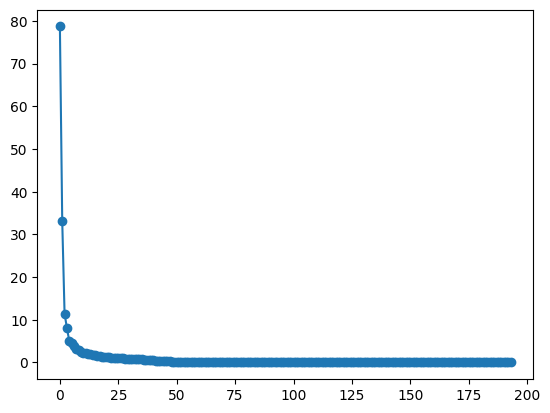

In [13]:
pca = PCA()
X_pca = pca.fit(X_scaled)
explain_variance = pca.explained_variance_ratio_
plt.plot(pca.explained_variance_, marker='o')

In [10]:
import optimise_xgb as oxgb
reload(oxgb)
import eval_metrics

eval_metric = eval_metrics.fbeta_eval

sys.stderr = open('optuna_errors.log', 'w')

params = oxgb.stepwise_optimisation(X, y, 3, eval_metric, data=os.path.splitext(data)[0], trials=10)

====== Optimising Group 1 ======
STUDY NAME:  xgboost
-------------------------------------------------------
EVALUATION METRIC:  fbeta_eval
-------------------------------------------------------
BEST CV SCORE:  0.4625484
-------------------------------------------------------
OPTIMAL GROUP - 1 PARAMS:  {'max_depth': 14, 'min_child_weight': 7.3924497885029625}
-------------------------------------------------------
BEST TRIAL FrozenTrial(number=100, state=1, values=[0.4625484], datetime_start=datetime.datetime(2025, 2, 19, 9, 49, 32, 893690), datetime_complete=datetime.datetime(2025, 2, 19, 9, 49, 54, 991987), params={'max_depth': 14, 'min_child_weight': 7.3924497885029625}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.46551219999999993, 1: 0.4658392, 2: 0.46704560000000006, 3: 0.467492, 4: 0.46896460000000006, 5: 0.46806220000000004, 6: 0.4670992, 7: 0.4666530000000001, 8: 0.4666456, 9: 0.4641197999999999, 10: 0.46441299999999996, 11: 0.4625484, 12: 0.46433179999999996, 

In [12]:
print(params)

{'num_boost_round': 200, 'learning_rate': 0.01, 'objective': 'multi:softprob', 'num_class': 3, 'gamma': 0.5682605273867319, 'max_depth': 18, 'min_child_weight': 5.7389146607612446e-08, 'subsample': 0.6210278383874708, 'colsample_bytree': 0.7689341785103883}


In [ ]:
params = stepwise_optimisation(X, y, 3, eval_metric, data=os.path.splitext(data)[0], trials=50)
params = stepwise_optimisation(X, y, 3, eval_metric, data=os.path.splitext(data)[0], trials=50)
params = stepwise_optimisation(X, y, 3, eval_metric, data=os.path.splitext(data)[0], trials=50)
params = stepwise_optimisation(X, y, 3, eval_metric, data=os.path.splitext(data)[0], trials=50)
params = stepwise_optimisation(X, y, 3, eval_metric, data=os.path.splitext(data)[0], trials=50)

====== Optimising Group 1 ======


KeyboardInterrupt: 